In [1]:
import subprocess
import os
import ete3
import random
import numpy as np
from Bio import SeqIO
import pandas as pd
import multiprocessing
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import random
from scipy.stats import spearmanr, linregress
import re

#
# initial definitions
class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

%cd /work/site_rate/sequence_simulation/indels
%matplotlib inline
num_replicates      = 100
sequence_length     = 5000
num_rate_categories = 12

/work/site_rate/sequence_simulation/indels


In [2]:
random.seed(12345)
np.random.seed(12345)

indelible_conf = '''\
/////////////////////////////////////////////////////////////////////////////////////
//                                                                                 //
//  INDELible V1.03 control file - site-rate project                               //
//                                                                                 //
//      Automaticaly generated, more information:                                  //
//          github.com/lthiberiol/fournierLab/tree/master/site_rates               //
//                                                                                 //
/////////////////////////////////////////////////////////////////////////////////////

[TYPE]  AMINOACID 1

[SETTINGS]
    [randomseed]   12345

[MODEL] modelHug [submodel]  LG                         //   LG
                 [indelmodel]   POW  1.7 500            // Power law insertion/deletion length distribution (a=1.7)
                 [indelrate]    0.1                     // insertion rate = deletion rate = 0.1
                                                        // relative to average substitution rate of 1.
                 [rates]     0 0.8025 20                //   pinv=0, alpha=1.3, discrete gamma categories=20
                 [statefreq]
                    0.0790   0.0843   0.0346   0.0392   // list of 20 numbers
                    0.0055   0.0293   0.0535   0.0956   // A R N D C
                    0.0217   0.0704   0.0699   0.1008   // Q E G H I
                    0.0253   0.0280   0.0415   0.0519   // L K M F P
                    0.0516   0.0065   0.0217   0.0898   // S T W Y V

[TREE] T3  {t3}

[PARTITIONS] partition3 [T3 modelHug {length}]   // tree T3, model model1, root length 1000

[EVOLVE]    partition3  {num_replicates}   {t3_name}
'''

taxa_names = [f'taxa_{count:04}' for count in range(1,101)]
base_tree  = ete3.Tree()
base_tree.populate(size=100, names_library=taxa_names, random_branches=True)

In [3]:
hug_tree                = ete3.Tree('../../hug_et_al/species.tre')
    
internal_branch_lengths = [node.dist for node in hug_tree.traverse()
                           if not node.is_root() and not node.is_leaf()]
leaf_branch_lengths     = [node.dist for node in hug_tree.get_leaves()]

#
# https://stackoverflow.com/questions/2896179/fitting-a-gamma-distribution-with-python-scipy
fit_alpha, fit_loc, fit_beta        = stats.gamma.fit(internal_branch_lengths)
internal_branch_length_distribution = stats.gamma(fit_alpha, loc=fit_loc, scale=fit_beta)

fit_alpha, fit_loc, fit_beta        = stats.gamma.fit(leaf_branch_lengths)
terminal_branch_length_distribution = stats.gamma(fit_alpha, loc=fit_loc, scale=fit_beta)

tree = base_tree.copy()
for node in tree.traverse():
    if node.is_root():
        continue
    elif node.is_leaf():
        tmp_branch_length = -1
        while tmp_branch_length < 0:
            tmp_branch_length = terminal_branch_length_distribution.rvs(1)[0]
        node.dist = tmp_branch_length
    else:
        tmp_branch_length = -1
        while tmp_branch_length < 0:
            tmp_branch_length = internal_branch_length_distribution.rvs(1)[0]
        node.dist = tmp_branch_length

In [4]:
out = open('control.txt', 'w')
out.write(indelible_conf.format(t3=tree.write(format=5, dist_formatter='%.20f'),
                                t3_name='hug_br_length',
                                num_replicates=num_replicates, length=sequence_length))
out.close()

subprocess.call(['/work/site_rate/indelible/INDELibleV1.03/bin/indelible_1.03_OSX_intel'])

0

In [6]:
fasta = open('hug_br_length.fas').read().strip()
tree.write(outfile='reference.tre', format=5, dist_formatter='%.20f')
for count, block in enumerate(fasta.split('\n     \n')):
    out = open('replicates_unaligned/%i.fas' % (count+1), 'w')
    out.write(block)
    out.close()

In [8]:
phylip = open('hug_br_length_TRUE.phy').read().strip()

for count, block in enumerate(phylip.split('\n     \n')):
    out = open('replicates_true_alignment//%i.phy' % (count+1), 'w')
    out.write(block)
    out.close()

In [42]:
#
# parse rates classification
#
%cd /work/site_rate/sequence_simulation/indels/mafft_aligned_rates/

if not os.path.isdir('categories'):
    os.mkdir('categories')
else:
    os.system('rm -r categories/*')

#for replicate in range(1, num_replicates+1):
for replicate in range(80, 101):
    if not os.path.isfile('%i.rate' % replicate):
        print(replicate)
        continue
    alignment = list(SeqIO.parse('../replicates_mafft_aligned/%i.aln' % replicate, 'fasta'))

    rates = pd.read_table('%i.rate' % replicate, comment='#')
    for category in rates.Cat.unique():
        site_df        = rates[rates.Cat == category]
        category_aln   = {sequence.name:'' for sequence in alignment}
        for sequence in alignment:
            category_aln[sequence.name] = ''.join([sequence[position] for position in site_df.index])

        out = open('categories/%i.%i.aln' % (replicate, category), 'w')
        for header, sequence in category_aln.items():
            full_sequence = ''
            while len(full_sequence) <= 5000:
                full_sequence += sequence
            if full_sequence[:5000].count('-') == 5000:
                continue
            out.write('>%s\n%s\n' % (header, full_sequence[:5000]))
        out.close()

/work/site_rate/sequence_simulation/indels/mafft_aligned_rates


In [45]:
#
# parse rates classification
#
%cd /work/site_rate/sequence_simulation/indels/true_alignment_rates/

if not os.path.isdir('categories'):
    os.mkdir('categories')
else:
    os.system('rm -r categories/*')

#for replicate in range(1, num_replicates+1):
for replicate in range(80, 101):
    if not os.path.isfile('%i.rate' % replicate):
        print(replicate)
        continue
    alignment = list(SeqIO.parse('../replicates_true_alignment/%i.phy' % replicate, 'phylip'))

    rates = pd.read_table('%i.rate' % replicate, comment='#')
    for category in rates.Cat.unique():
        site_df        = rates[rates.Cat == category]
        category_aln   = {sequence.name:'' for sequence in alignment}
        for sequence in alignment:
            category_aln[sequence.name] = ''.join([sequence[position] for position in site_df.index])

        out = open('categories/%i.%i.aln' % (replicate, category), 'w')
        for header, sequence in category_aln.items():
            full_sequence = ''
            while len(full_sequence) <= 5000:
                full_sequence += sequence
            if full_sequence[:5000].count('-') >= 5000:
                continue
            out.write('>%s\n%s\n' % (header, full_sequence[:5000]))
        out.close()

/work/site_rate/sequence_simulation/indels/true_alignment_rates


In [27]:
import matplotlib.colors

cmap = plt.cm.RdBu_r
norm = matplotlib.colors.Normalize(vmin=-1, vmax=12)
colors = ['#%02x%02x%02x' % cmap(norm(index), bytes=8)[:3]
          for index in range(0,13)]

In [47]:
subprocess.call(['iqtree', '-t', '%i.%i.ufboot' % (n, category), 
                         '-rf', 'tmp_reference.tre']
                       )

0

/work/site_rate/sequence_simulation/indels/true_alignment_rates/categories


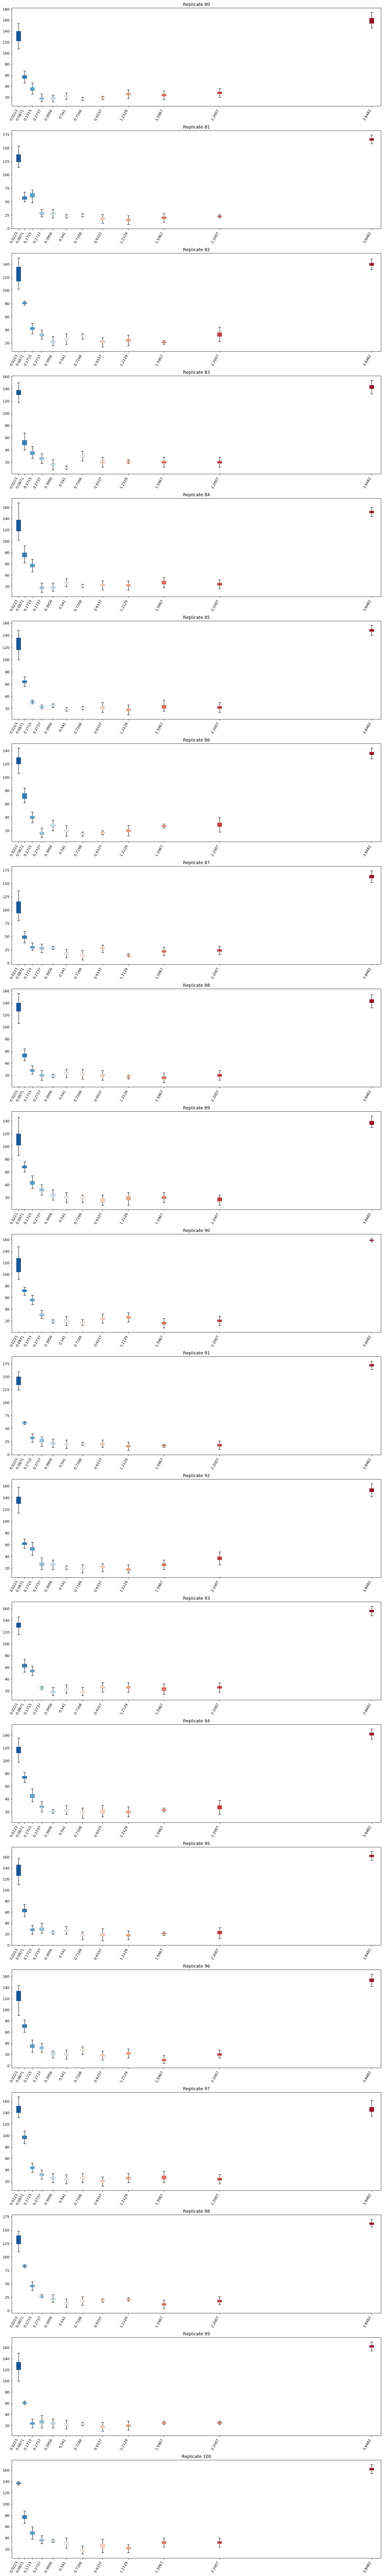

In [53]:
%cd /work/site_rate/sequence_simulation/indels/true_alignment_rates/categories/

random.seed(12345)
#fig, axs = plt.subplots(dpi=200, figsize=(10,300), nrows=93)
fig, axs = plt.subplots(dpi=180, figsize=(15,100), nrows=21)
ax_counter = -1
#for replicate in range(1, 101):
for n in range(80, 101):
#    if not all(os.path.isfile('%i.%i.rfdist' % (replicate, category)) 
#               for category in range(1, 13)):
#        print('%i\n\tmissing one of the categories' % n)
#        continue

    ax_counter += 1
    distances = []
    for category in range(1,13):
        tmp_tree = ete3.Tree('../../reference.tre')
        taxa     = re.findall('^>(\S+)', open('%i.%i.aln' % (n, category)).read(), re.M)
        
        if len(taxa) < len(tmp_tree):
            tmp_tree.prune(taxa)
        tmp_tree.unroot()
        tmp_tree.write(outfile='tmp_reference.tre', format=9, dist_formatter='%.20f')
        
        subprocess.call(['iqtree', '-t', '%i.%i.ufboot' % (n, category), 
                         '-rf', 'tmp_reference.tre']
                       )

        iqtree_result = open('%i.%i.ufboot.rfdist' % (n, category)).readlines()
        iqtree_result.pop(0)
        distances.append([int(line.split()[1]) for line in iqtree_result])
    
    rates     = pd.read_table('../%i.rate' % replicate, comment='#')
    rates.drop_duplicates('Cat', inplace=True)
    rates.sort_values('Cat', inplace=True)

    boxplot = axs[ax_counter].boxplot(distances, positions=rates.C_Rate.tolist(),
                         widths=0.05,
                         patch_artist=True,
                         showfliers=False,
                         boxprops={'linewidth':0.1},
                         whiskerprops={'linewidth':1},
                         medianprops={'linewidth':0.1,
                                      'color':'k'})
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)
    
    axs[ax_counter].set_xticklabels([round(n, 4) for n in rates.C_Rate.tolist()], rotation=60, ha='right')
    axs[ax_counter].set_xlim(-0.05, rates.C_Rate.tolist()[-1]+0.1)
    axs[ax_counter].set_title('Replicate %i' % n)
fig.tight_layout()

/work/site_rate/sequence_simulation/indels/mafft_aligned_rates/categories


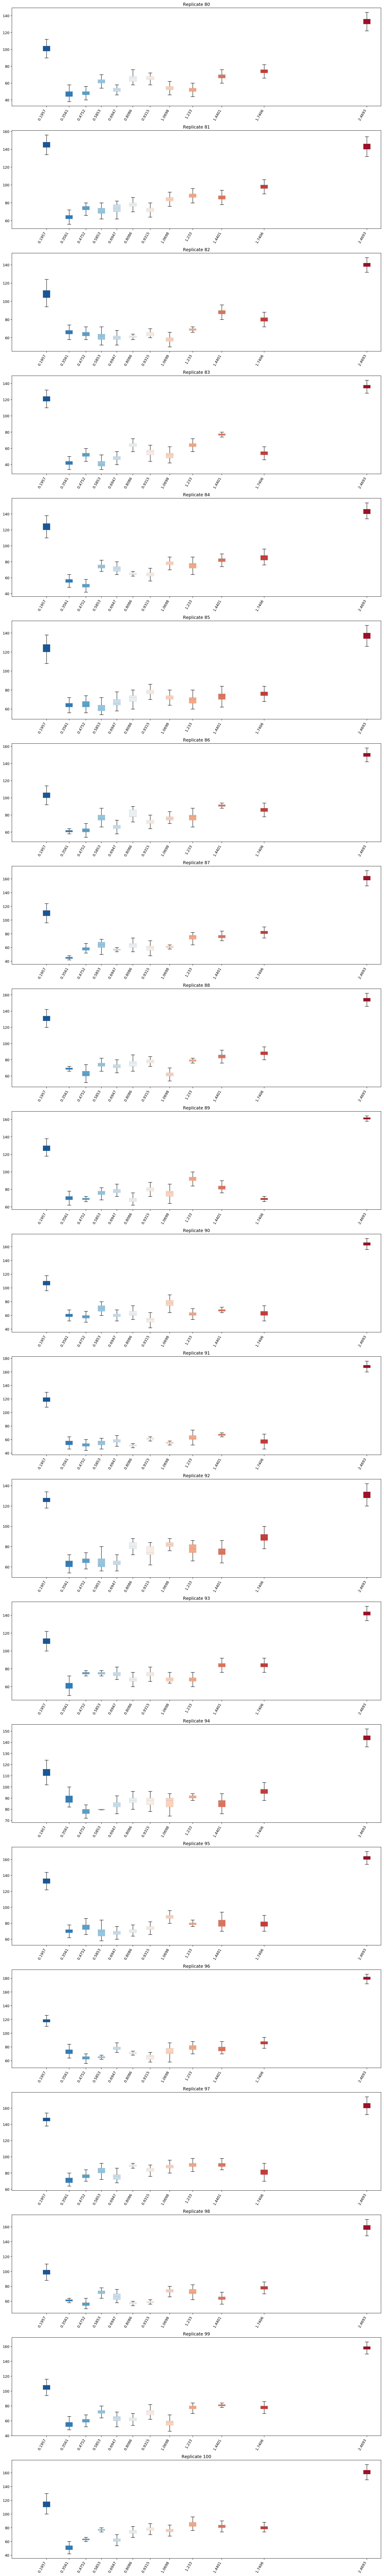

In [52]:
%cd /work/site_rate/sequence_simulation/indels/mafft_aligned_rates/categories/

random.seed(12345)
#fig, axs = plt.subplots(dpi=200, figsize=(10,300), nrows=93)
fig, axs = plt.subplots(dpi=180, figsize=(15,100), nrows=21)
ax_counter = -1
#for replicate in range(1, 101):
for n in range(80, 101):
    ax_counter += 1
    distances = []
    for category in range(1,13):
        tmp_tree = ete3.Tree('../../reference.tre')
        taxa     = re.findall('^>(\S+)', open('%i.%i.aln' % (n, category)).read(), re.M)
        
        if len(taxa) < len(tmp_tree):
            tmp_tree.prune(taxa)
        tmp_tree.unroot()
        tmp_tree.write(outfile='tmp_reference.tre', format=9, dist_formatter='%.20f')
        
        subprocess.call(['iqtree', '-t', '%i.%i.ufboot' % (n, category), 
                         '-rf', 'tmp_reference.tre']
                       )

        iqtree_result = open('%i.%i.ufboot.rfdist' % (n, category)).readlines()
        iqtree_result.pop(0)
        distances.append([int(line.split()[1]) for line in iqtree_result])
    
    rates     = pd.read_table('../%i.rate' % replicate, comment='#')
    rates.drop_duplicates('Cat', inplace=True)
    rates.sort_values('Cat', inplace=True)

    boxplot = axs[ax_counter].boxplot(distances, positions=rates.C_Rate.tolist(),
                         widths=0.05,
                         patch_artist=True,
                         showfliers=False,
                         boxprops={'linewidth':0.1},
                         whiskerprops={'linewidth':1},
                         medianprops={'linewidth':0.1,
                                      'color':'k'})
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)
    
    axs[ax_counter].set_xticklabels([round(n, 4) for n in rates.C_Rate.tolist()], rotation=60, ha='right')
    axs[ax_counter].set_xlim(-0.05, rates.C_Rate.tolist()[-1]+0.1)
    axs[ax_counter].set_title('Replicate %i' % n)
fig.tight_layout()